In [16]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import mne
import scipy
from mne.datasets.sleep_physionet.age import fetch_data

import epoch

In [3]:
psg_file = "data/SC4001E0-PSG.edf"
psg_data = mne.io.read_raw_edf(psg_file)

Extracting EDF parameters from /Users/stig/Desktop/- TU:e/5Q1 ITBA Buenos Aires/72.75 Aprendizarje Automatico/72.75-ML/final/data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
fs = psg_data.info.get('sfreq')
print(fs,'Hz')

data = psg_data.get_data()
data.shape

100.0 Hz


(7, 7950000)

In [5]:
secs = data.shape[1]/fs
print(f'{secs} segundos')
print(f'{secs/60} minutos')
print(f'{secs/60/60} horas')


print(psg_data.ch_names)
print(psg_data.get_channel_types())
print(len(psg_data['EEG Fpz-Cz'][0][0]))

79500.0 segundos
1325.0 minutos
22.083333333333332 horas
['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
7950000


In [6]:
len(psg_data['EEG Fpz-Cz'][0][0])
t = psg_data['EEG Fpz-Cz'][1]
t

array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 7.949997e+04,
       7.949998e+04, 7.949999e+04])

In [7]:
print(psg_data.info.get('ch_names'))
EEG_Fpz_Cz, EEG_Pz_Oz, EOG_Horizontal, Resp_oro_nasal, EMG_submental, Temp_rectal, Event_marker= data[0], data[1], data[2], data[3], data[4], data[5], data[6]

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


In [8]:
#add annotations
hypnogramm_file = "data/SC4001EC-Hypnogram.edf"
hypnogramm_annotations = mne.read_annotations(hypnogramm_file)
psg_data.set_annotations(hypnogramm_annotations)


/var/folders/fk/bp84qn853hzcw2qn55kxcqc40000gn/T/ipykernel_65090/2458527308.py:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  psg_data.set_annotations(hypnogramm_annotations)


Measurement date,"April 24, 1989 16:13:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,7 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


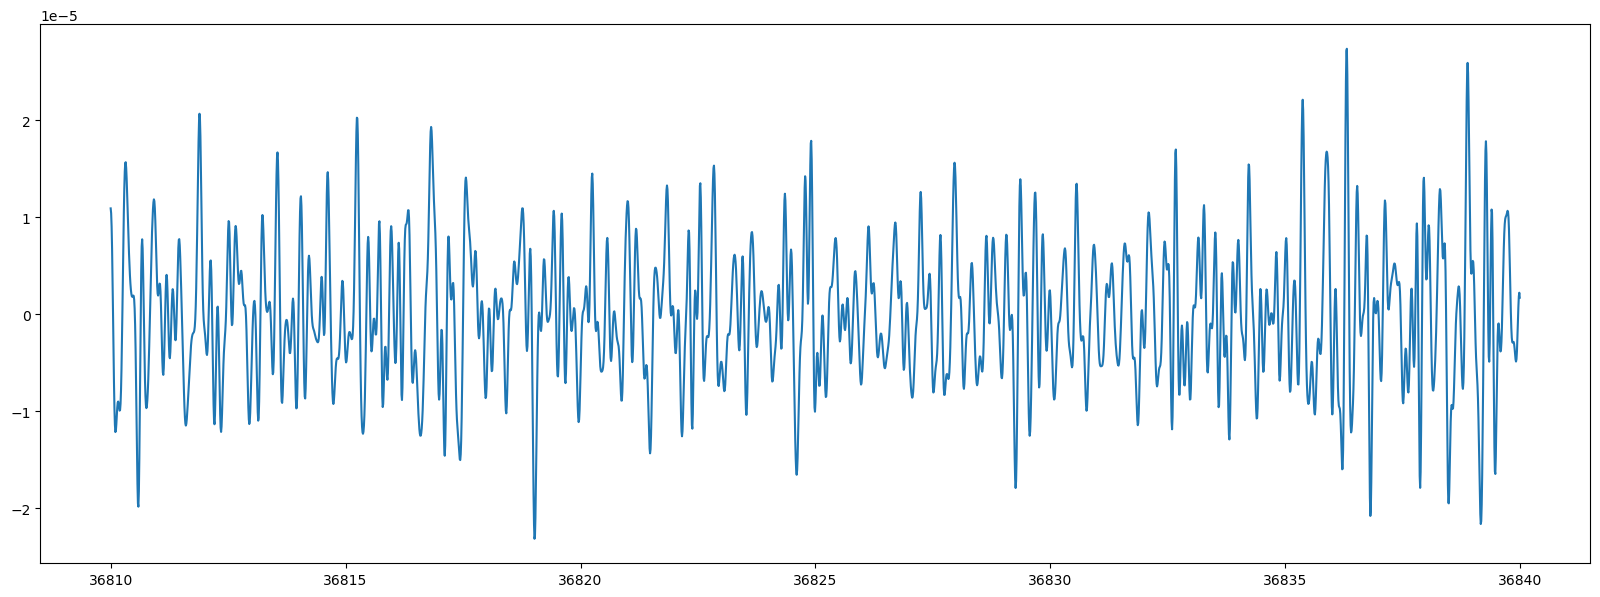

2


In [9]:


EPOCH_LENGTH = 30
epoch = 1227
epoch_start = int(epoch*EPOCH_LENGTH*fs)
epoch_end = int((epoch + 1)*EPOCH_LENGTH*fs)    


# FILTRADO
N = 5 # Orden del filtro
wn = [1,10] # Frecuencias de corte del filtro
sos = scipy.signal.butter(N, wn, btype = 'bandpass', output = 'sos', fs = fs) # Diseño el filtro
filtrada = scipy.signal.sosfiltfilt(sos, EEG_Fpz_Cz) # Filtro la señal


plt.figure(figsize=(20,7))
#plt.plot(t[epoch_start:epoch_end] ,EEG_Fpz_Cz[epoch_start:epoch_end])
plt.plot(t[epoch_start:epoch_end] ,filtrada[epoch_start:epoch_end])
plt.show()



start_datetime = psg_data.info['meas_date']
a = psg_data.annotations.copy().crop(
    start_datetime.timestamp() + epoch * EPOCH_LENGTH,
    start_datetime.timestamp() + epoch * EPOCH_LENGTH + EPOCH_LENGTH)
print(len(a))

Using matplotlib as 2D backend.


/var/folders/fk/bp84qn853hzcw2qn55kxcqc40000gn/T/ipykernel_65090/1301172632.py:1: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  psg_data.plot(start = epoch*EPOCH_LENGTH, duration = EPOCH_LENGTH)


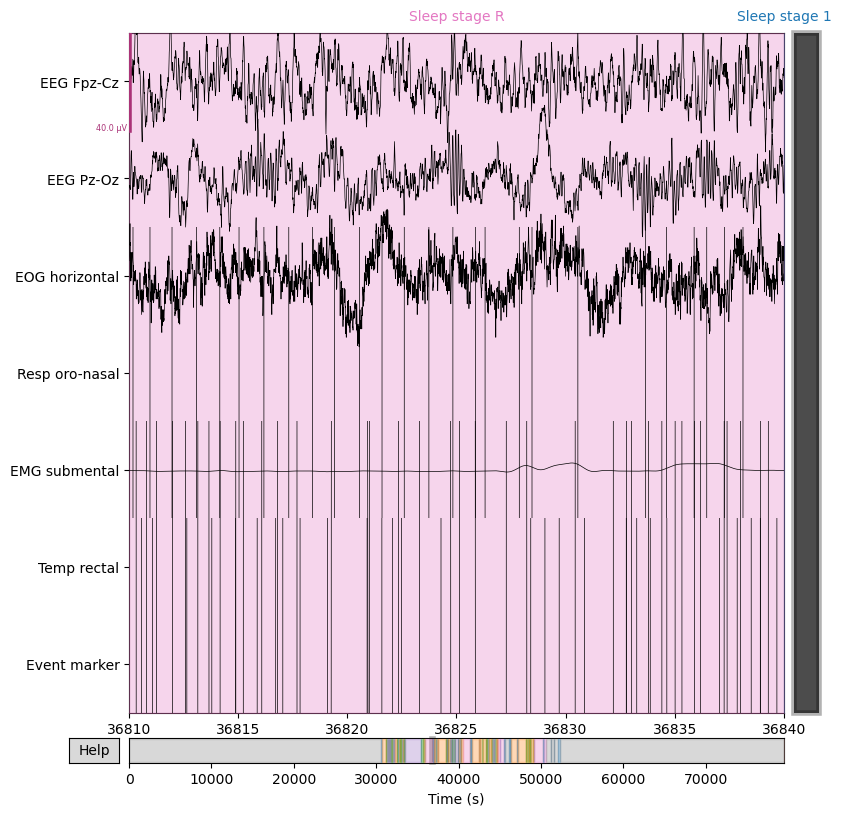

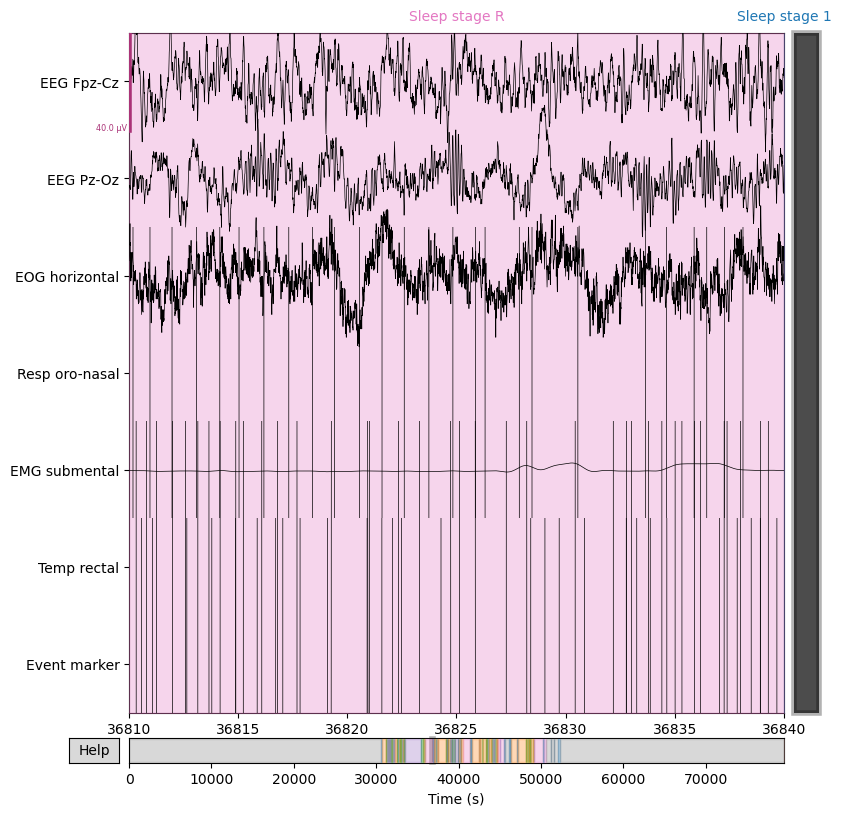

In [10]:
psg_data.plot(start = epoch*EPOCH_LENGTH, duration = EPOCH_LENGTH)

In [14]:
s = epoch.sleepRecording()
s.init_from_file("data/SC4001E0-PSG.edf","data/SC4001EC-Hypnogram.edf")

Extracting EDF parameters from /Users/stig/Desktop/- TU:e/5Q1 ITBA Buenos Aires/72.75 Aprendizarje Automatico/72.75-ML/final/data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/stig/Desktop/- TU:e/5Q1 ITBA Buenos Aires/72.75 Aprendizarje Automatico/72.75-ML/final/epoch.py:33: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  psg_data_raw.set_annotations(hypnogramm_annotations)
